# Eye-Blink Detection
This notebook is an exploratory analysis of some preliminary data for the 2021-2022 weeping angel car project. This is our testing space for trying out different analysis approaches.

## Preliminary Analysis

Our goals for the analysis are:
1. Detect normal eyeblinks
2. Detect normal eyeblinks from only the first 0.5 seconds of a blink
3. Separate normal eyeblinks from driving eye blinks
4. Detect which eye the eyeblinks are coming from

### Dataset Description

The following is a description of the recordings that are tested throughout this notebook.

- **Matt/Blinks_60s_BlinkEvery5s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt blinked once with both eyes every 5 seconds for a minute.

- **Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt forcefully closed his left eye for 2s, then kept it open for 8s. The whole time, he was blinking normally and comfortably with both eyes.

- **Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt forcefully closed his right eye for 2s, then kept it open for 8s. The whole time, he was blinking normally and comfortably with both eyes.

- **Alex/LeftDrivingBlinks_WithHat_ClosedRight_5s**: Recorded November 26, 2021 at Alex's house, on Alex's laptop. The muse was used with a hat to hold it in place. Alex held his right eye closed, and winked his left eye every 5s.

- **Alex/RightDrivingBlinks_WithHat_ClosedLeft_5s**: Recorded November 26, 2021 at Alex's house, on Alex's laptop. The muse was used with a hat to hold it in place. Alex held his left eye closed, and winked his right eye every 5s.

### Loading in the Data and Labelling Eyeblinks
We want to load in the data and prepare it to be analyzed. To do this, we'll store the actual values in pandas dataframes, which are python data structures that resemble spreadsheets, and are frequently used to store lots of tabular data. These dataframes really store the actual data inside a numpy array.

Once we have the data, we'll want to load it into MNE, by using it to initialize a RawData object in MNE.

Finally, we want to separate the eyeblinks so that we know which stretches of time contain eyeblinks, and which don't. Earlier versions of this notebook used a crude thresholding approach for recognizing eyeblinks in general (see github if you're interested), but in this version We'll do this using the built-in MNE functionality for detecting blinks.

In [1]:
# Load in the data as pandas dataframes
import pandas as pd
# Keep a dictionary so we can index each dataset by name
raw_recordings = {"Matt_NormalBlinks": pd.read_csv("Data/Matt/Blinks_60s_BlinkEvery5s.csv"), 
                "Matt_DrivingBlinksLeft": pd.read_csv("Data/Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s.csv").iloc[:-500], 
                "Matt_DrivingBlinksRight": pd.read_csv("Data/Matt/DrivingBlinksRightEye_120s_BlinkEvery10sFor2s.csv"),
                "Alex_LeftWinkWithHat": pd.read_csv("Data/Alex/LeftDrivingBlinks_WithHat_ClosedRight_5s.csv"), 
                "Alex_RightWinkWithHat": pd.read_csv("Data/Alex/RightDrivingBlinks_WithHat_ClosedLeft_5s.csv")}
# Print the head of the dataframes so we can verify that it imported properly
for key in raw_recordings.keys():
    print(f"\n{key}")
    print(raw_recordings[key].head())


Matt_NormalBlinks
   timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1635968532   3.418  36.621  33.691  24.902     61.035
1  1635968532 -18.066  36.621  32.227  30.273     67.871
2  1635968532  32.227  31.250  31.250  25.879     94.238
3  1635968532  88.867  30.273  31.738  15.137    110.352
4  1635968532  27.832  31.738  35.645  16.602     94.727

Matt_DrivingBlinksLeft
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.635970e+09  83.984  25.391  26.367  13.184     48.340
1  1.635970e+09  39.551  20.508  27.832  17.578     52.246
2  1.635970e+09 -17.578  13.184  35.645  17.578     34.180
3  1.635970e+09  -6.348  14.648  30.273  16.602     40.527
4  1.635970e+09  55.176  17.090  15.137  14.648     48.828

Matt_DrivingBlinksRight
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.635969e+09  69.824  39.551  38.086  40.039    104.492
1  1.635969e+09  93.750  35.156  26.367  27.832     18.066
2  1.635969e+09  -5.371  32.227  40.527  27.344     -9.766


Now, we are ready to create the MNE objects that we'll use for the rest of the analysis:

In [2]:
# Import MNE
import mne
# Tell MNE to not bother us with outputs unless something's wrong
mne.set_log_level("WARNING")

# Create the info object that stores our metadata
info = mne.create_info(["timestamps","TP9","AF7","AF8", "TP10", "Right AUX"], 256, ch_types="eeg")

# Create the MNE raw data object using the raw data (.values.T to extract the values only, and transpose to make it in the format MNE wants)
raw_data = {dataset_name : mne.io.RawArray(raw_recordings[dataset_name].values.T, info) for dataset_name in raw_recordings.keys()}
#notchfiltered_data = {raw_data[dataset_name].notch_filter([60, 120], picks=["TP9","AF7","AF8", "TP10"]) for dataset_name in raw_data.keys()}
#bandpassfiltered_data = {raw_data[dataset_name].filter(20, 50, picks=["TP9","AF7","AF8", "TP10"], method="fir") for dataset_name in raw_data.keys()}

# Create the MNE Epochs object using the Blink column
epoched_data = {dataset_name: mne.preprocessing.create_eog_epochs(raw_data[dataset_name], ch_name=["TP9","AF7","AF8", "TP10"]) for dataset_name in raw_recordings.keys()}

# Create the MNE Evoked object using the epochs
evoked_data = {dataset_name : epoched.average(picks="all") for dataset_name, epoched in epoched_data.items()}

## Checking the Dataset

Let's do some checks to see if the data as a whole contains a reliable blink-signal that we can try to detect. Let's start with the power spectral densities to see if we have any weird signals. 

C:\Users\alexp\AppData\Local\Temp/ipykernel_9000/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


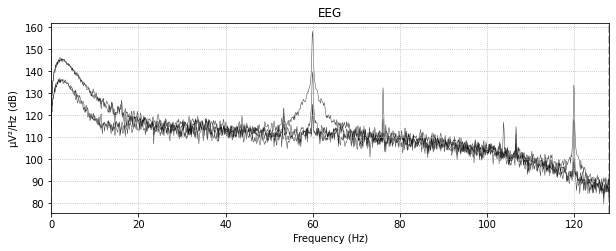

C:\Users\alexp\AppData\Local\Temp/ipykernel_9000/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


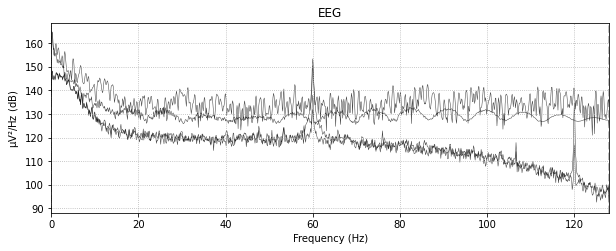

C:\Users\alexp\AppData\Local\Temp/ipykernel_9000/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


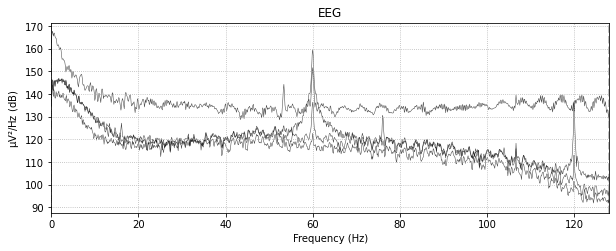

C:\Users\alexp\AppData\Local\Temp/ipykernel_9000/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


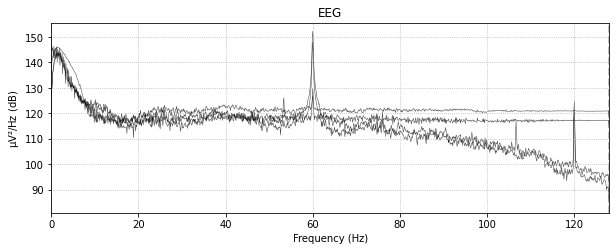

C:\Users\alexp\AppData\Local\Temp/ipykernel_9000/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


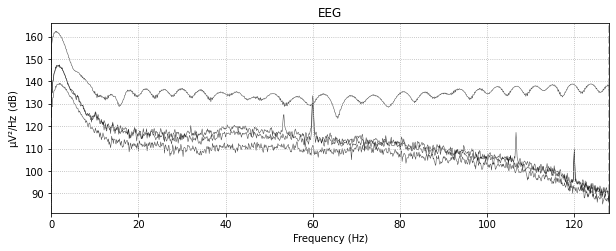

In [3]:
# Plot the PSDs of the data so we can see what the frequency content is like.
for key, data in raw_data.items():
    data.plot_psd(picks=["AF7","AF8","TP9","TP10"])

As expected, some of the datasets (especially Matt's, which were recorded in Thode basement) have some significant 60 Hz signal. Some of this is due to power line noise, but some of it is actual eyeblink signal. The eyeblink signals last about 1s, meaning they have significant 60 Hz contribution, and filtering out the powerline noise would remove them as well.

There are definitely also some strange features to these plots that should be investigated:
- What's causing those waves in the plots?

Let's visualize the epochs and see if we can notice any patterns in the averaged-out eyeblinks.

C:\Users\alexp\AppData\Local\Temp/ipykernel_18204/3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


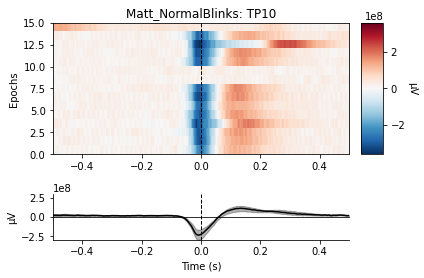

C:\Users\alexp\AppData\Local\Temp/ipykernel_18204/3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


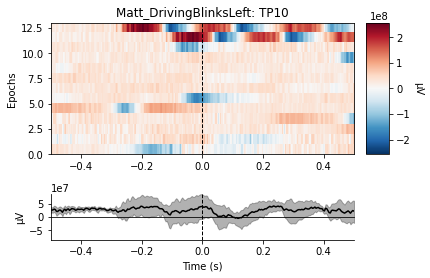

C:\Users\alexp\AppData\Local\Temp/ipykernel_18204/3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


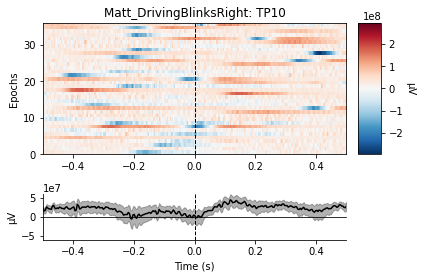

C:\Users\alexp\AppData\Local\Temp/ipykernel_18204/3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


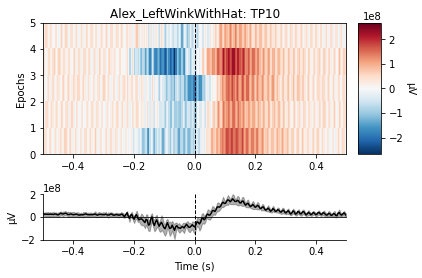

C:\Users\alexp\AppData\Local\Temp/ipykernel_18204/3333842092.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


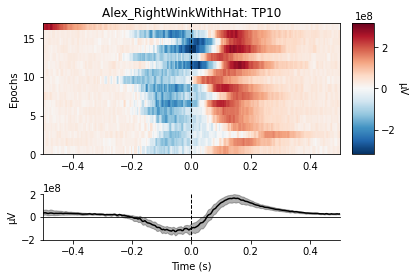

In [7]:
channel_to_plot = "TP10"
for key, dataset in epoched_data.items():
    dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")

There is clearly a general trend in the eyeblinks, Since stacking them up like this shows that the dips in the signal (blue) and rises in the signal (red) happen at roughly the same time with each eyeblink. Since they follow similar patterns, this justifies looking at the *average* signal for each of these blink-types.

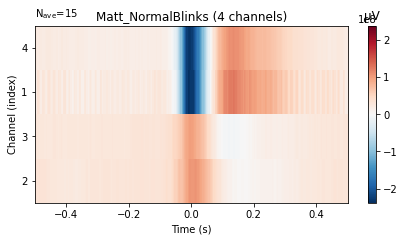

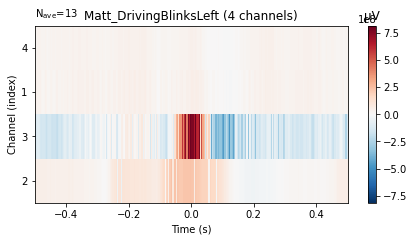

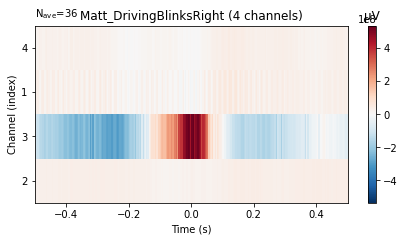

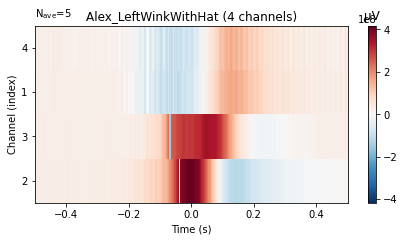

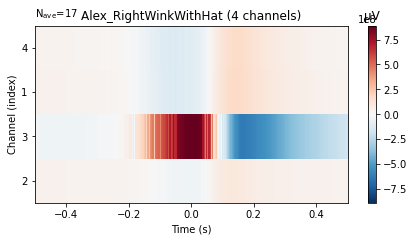

In [8]:
for key, evoked in evoked_data.items():
    evoked.plot_image(picks=["AF7","AF8","TP9","TP10"], titles=key)

These plots show the asymmetry that exists in people's eyeblinks. Despite this, the signals are different, and we should be able to distinguish between left, right, and normal winks. Some approaches to this are tested out below.

## Idea #1: Window Variance

### Explanation of the Idea
We might be able to distinguish between normal and driving blinks using the variance of the signal in a given window. We expect that both normal and driving blinks will lead to large variances on their windows, but driving blinks should have more due to the muscle contractions that are involved with shutting your eye so forcefully. 

### Method
To do this, we need to pick a window size on which to calculate the variance. Since a normal blink takes roughly 200 timesteps, we can use 200 as the window size. For the step length, let's use 1 for now. This will change based on the processing latency when we actually stream data in real-time.

### Results
Below, we find the variance for each window, and plot the variance of a window on the y-axis vs the index of the window's start. Superimposing this variance signal with the eyeblinks shows that it picks up the normal eyeblinks pretty well, but the driving blinks have a messy variance signal.

Also, the hope was that the variance has different peaks between normal and driving blinks. To check this, we plotted a histogram of the peaks in the variance. While the normal blinks have a pretty nicely-distributed peak height, the mix of normal and driving blinks is not as bimodal as we would have hoped. If we see two separate peaks, then we can say that the lower and higher peaks in the distribution of variances correspond to the different kinds of blinks. Unfortunately, we don't see that.

### Future Approach
The fact that this approach doesn't work may be due to the difference in the duration of normal and driving blinks, so on a window that is the size of normal blinks, you'll get good detection of normal blinks but the driving blinks will be split across multiple windows and therefore they won't pop out as much. For windows that are the size of driving blinks, we'll pick up their variance very easily, but normal blinks will get "washed out" since they will only occupy a small fraction of the window.

Matt_NormalBlinks


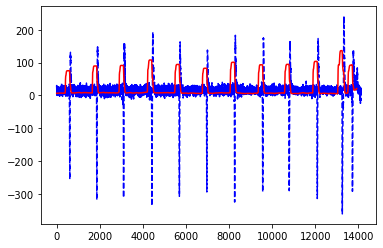

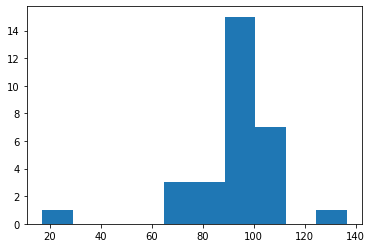

Matt_DrivingBlinksLeft


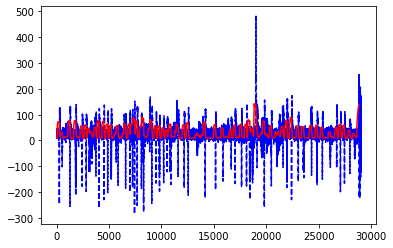

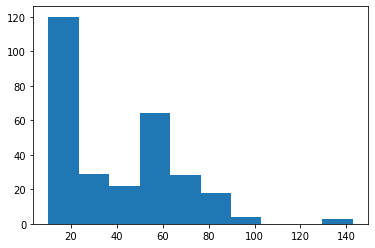

Matt_DrivingBlinksRight


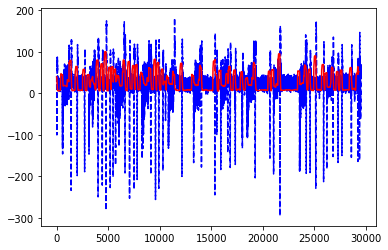

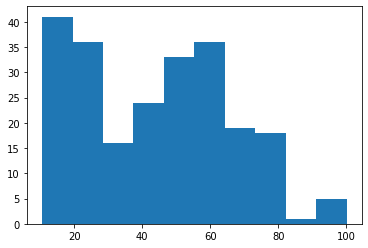

Alex_LeftWinkWithHat


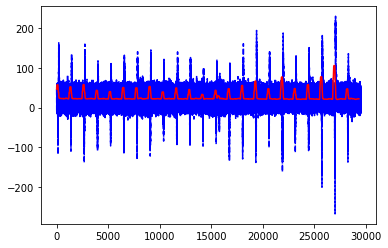

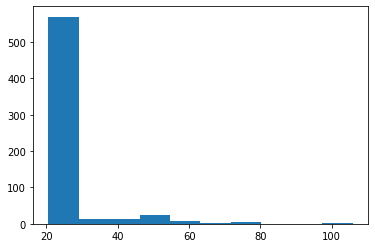

Alex_RightWinkWithHat


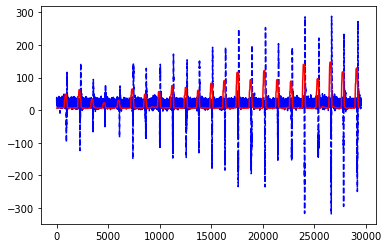

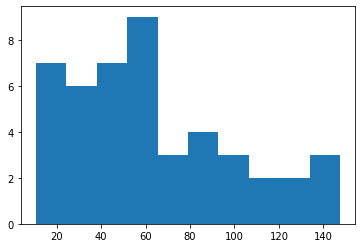

In [10]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
for key, dataset in raw_recordings.items():
    print(key)
    variance_list = []
    for window_start in range(0, dataset["timestamps"].size - 200, 10):
        window_stop = window_start + 200
        channelname = "TP10"
        variance_list.append(np.std(dataset[channelname][window_start:window_stop]))
    #plt.plot(dataset[channelname])
    variance_list = np.array(variance_list)
    non_baseline = variance_list[variance_list > 10]

    plt.plot(dataset[channelname], "--b")
    plt.plot(range(0, dataset["timestamps"].size - 200, 10), variance_list, "r-")

    plt.show()
    plt.hist(non_baseline[signal.argrelextrema(non_baseline, np.greater)[0]])
    plt.show()

## Idea #2: Template-Matching

### Explanation of the Idea
We can use the average left, right, and normal eye-blink as a "template" for what left, right, and normal blinks look like respectively. If we slide this template along the data, we can take a window that is the size of the template and ask how well the template "fits" to the data in that window. In each window, we can predict which kind of blink (if any) is occurring, based on which template fits the data the best.

### Methods
To try this out, we use the evoked potentials from the "Loading in and Preparing the Dataset" section to generate the templates. To see hwo well the templates can distinguish between the different blinks and users, we chose a single template to use on all the recordings. Then, we divide the chosen template by a constant factor 10^6 to account for the conversion from MNE object to pandas dataframe. Since MNE automatically thinks all EEG data is in Volts (and are therefore really small), it converts them to microvolts to make them easier to interpret. In our case, the data is already in microvolts, so MNE scales them up by an extra factor of 10^6 which we don't want. There might be a way to tell MNE to not do this conversion, but I haven't found it yet.

Once we have the template, we slide this template across all channels of the dataset, and and take the chi-squared value in each window. The plots below show the raw data in blue, and the chi-squared value for the *window beginning on that position* in orange. 

### Results
As expected, there is a dip in the chi-squared in the position that corresponds to the start of the window containing the eyeblink. The problem is, that any template tends to produce these dips in any dataset. For example, using Matt_NormalBlinks as the template produces the dips even in Alex_LeftWinksWithHat, albeit more rarely. 

This is likely due to the fact that there is comparable variation between the same blinks/winks from the same person, as the variation between different blinks/winks between different people. So a template fits its own data roughly as well as it fits anyone else's data.

### Future Approach
If the conclusion above is correct, it will likely be a problem for all of our future appraoches too, and should be investigated statistically to see if the claim is correct. In this case, one possible solution is to practice winks so that they are consistent enough that templates from one data set do not work too well on others. In any one person becomes really good at having consistent winks, then their templates will be more specific to them and less likely to work on a different one of their winks.

Alternatively, we could analyze the distributions of the chi-squared values, particularly the minima, to see if maybe the templates do consistently have better fits on their own data than others, just not visibly.

Finally, we can also try using a different approach to see how well the template fits the data. One stragey could be convolution.

In [12]:
# Get the templates out of the data
templates = {key : dataset.to_data_frame(picks=["AF7", "AF8", "TP9", "TP10"]) for key, dataset in evoked_data.items()}

# Go through the data in chunks of size "window_size" and check the chi-squared
# For each channel in "channels" using the corresponding template
step_length = 1
channels = ["TP9", "TP10"]
chi_squareds = {dataset_name: {channel_name : [] for channel_name in channels} for dataset_name in templates.keys()}

# Go through each dataset in the raw_recording dictionary
for key, dataset in raw_recordings.items():
    # Get the window size for this dataset based on the length of the template
    template_to_use = "Alex_RightWinkWithHat"
    window_size = templates[template_to_use]["time"].size
    # Grab the template from the templates dictionary
    template = templates[template_to_use].divide(10**6)
    # Go through the raw_recording in steps of window_size
    for i in range(0, dataset["timestamps"].size - window_size, 1):
        # Get the window
        window = dataset.iloc[i:i+window_size]
        # Apply the template to each channel and store the corresponding chi_squared
        for channel in channels:
            chi_squared = ((window[channel].values - template[channel].values)**2).sum() / window_size**2
            chi_squareds[key][channel].append(chi_squared)

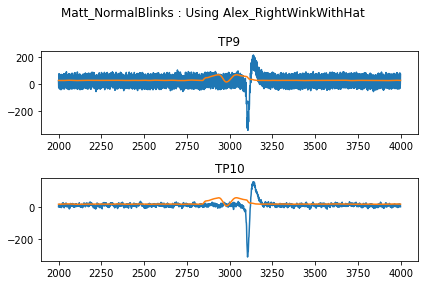

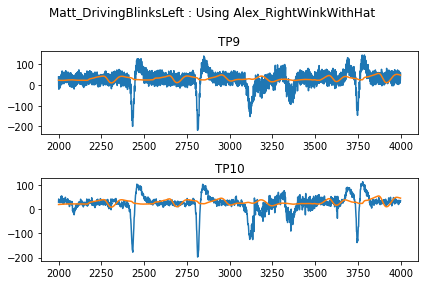

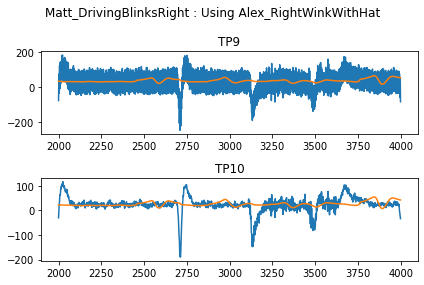

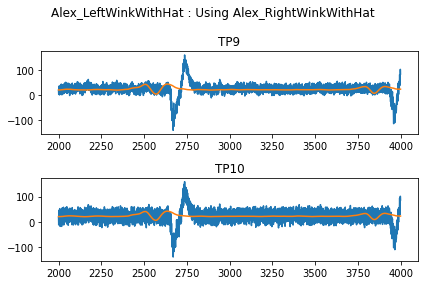

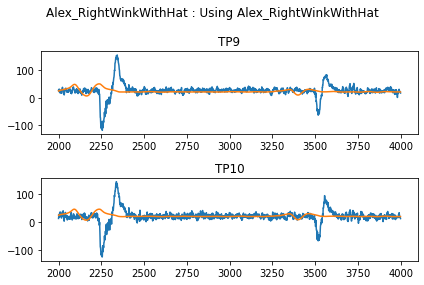

In [126]:
# Plot so we can see how well we distinguish
left = 2000
right = 4000
for key in templates.keys():
    fig, ax = plt.subplots(2,1)
    fig.suptitle(f"{key} : Using {template_to_use}")
    for channel_idx in range(len(channels)):
        channel = channels[channel_idx]
        ax[channel_idx].plot(raw_recordings[key][channel][left:right])
        ax[channel_idx].plot(range(left, right), (np.array(chi_squareds[key][channel]))[left:right])
        ax[channel_idx].set_title(f"{channel}")
    plt.tight_layout()
    plt.show()